In [32]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import numpy as np
import progressbar
import dill as pickle
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/mjoppich/.local/lib/python3.6/site-packages', '/home/mjoppich/.local/lib/python3.6/site-packages/mpld3-0.3.1.dev1-py3.6.egg', '/home/mjoppich/.local/lib/python3.6/site-packages/opennre-0.1-py3.6.egg', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/tf_unet-0.1.1-py3.6.egg', '/mnt/d/PythonCGI/jupyter_micropython_kernel', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../', '../']


In [3]:
imze = IMZMLExtract("/mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML")

Opening regions file for /mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML


0 ((356, 400, 215, 273), 2655)
1 ((436, 478, 632, 687), 2408)
2 ((1572, 1612, 608, 666), 2419)
3 ((1149, 1197, 142, 205), 3136)
4 ((618, 666, 211, 266), 2744)
5 ((633, 684, 630, 688), 3068)
6 ((1357, 1400, 628, 686), 2596)


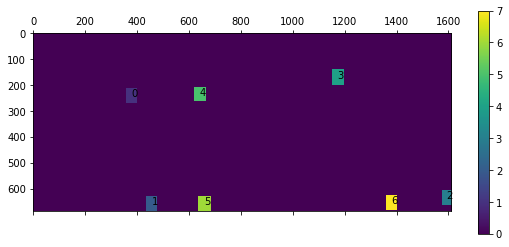

{0: ((356, 400, 215, 273), 2655),
 1: ((436, 478, 632, 687), 2408),
 2: ((1572, 1612, 608, 666), 2419),
 3: ((1149, 1197, 142, 205), 3136),
 4: ((618, 666, 211, 266), 2744),
 5: ((633, 684, 630, 688), 3068),
 6: ((1357, 1400, 628, 686), 2596)}

In [4]:
imze.list_regions()

In [5]:
spectra_orig = imze.get_region_array(0, makeNullLine=True)
spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")
spectra = imze.normalize_region_array(spectra_intra, normalize="inter_median")

Found region 0 with shape (45, 59, 17900)
I0702 21:27:01.258399 139755279877952 segment.py:2482] Found region 0 with shape (45, 59, 17900)
I0702 21:27:05.808556 139755279877952 segment.py:2196] Collecting fold changes
Got a total of 47524500 fold changes
I0702 21:28:00.835250 139755279877952 segment.py:2207] Got a total of 47524500 fold changes
Median elements [23762250]
I0702 21:28:03.867632 139755279877952 segment.py:2216] Median elements [23762250]
Median elements
I0702 21:28:05.210200 139755279877952 segment.py:2229] Median elements
Global Median
I0702 21:28:05.211855 139755279877952 segment.py:2234] Global Median


3454.87441091502 39
3456.383544128344 278
3457.8926773416683 2332
4965.516757452595 2
14980.124761072322 2
14981.633894285647 2


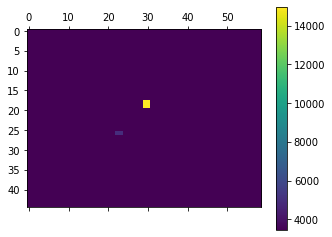

2655 21.59712531890812 135.29843099154667 64.38364844499411


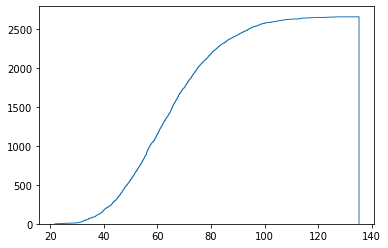

In [10]:
imze.list_highest_peaks(spectra, counter=True)

In [6]:
spec = SpectraRegion(spectra, imze.mzValues)

In [7]:
spec.calculate_similarity(mode="spectra_log")

(45, 59, 17900)


2020-07-02 21:28:50,756  SpectraRegion  INFO: Creating C++ obj
I0702 21:28:50.756982 139755279877952 segment.py:496] Creating C++ obj
2020-07-02 21:28:50,759  SpectraRegion  INFO: dimensions 17900
I0702 21:28:50.759258 139755279877952 segment.py:506] dimensions 17900
2020-07-02 21:28:50,761  SpectraRegion  INFO: input dimensions (45, 59, 17900)
I0702 21:28:50.761107 139755279877952 segment.py:507] input dimensions (45, 59, 17900)
2020-07-02 21:28:50,763  SpectraRegion  INFO: Switching to dot mode
I0702 21:28:50.763689 139755279877952 segment.py:510] Switching to dot mode
2020-07-02 21:28:50,767  SpectraRegion  INFO: Starting calc similarity c++
I0702 21:28:50.767162 139755279877952 segment.py:514] Starting calc similarity c++


17900


2020-07-02 21:30:04,977  SpectraRegion  INFO: outclust dimensions (2655, 2655)
I0702 21:30:04.977950 139755279877952 segment.py:519] outclust dimensions (2655, 2655)
2020-07-02 21:30:05,007  SpectraRegion  INFO: Calculating spectra similarity
I0702 21:30:05.007480 139755279877952 segment.py:553] Calculating spectra similarity


(2655, 2655)


2020-07-02 21:30:05,255  SpectraRegion  INFO: Calculating spectra similarity done
I0702 21:30:05.255388 139755279877952 segment.py:557] Calculating spectra similarity done


array([[1.        , 0.976177  , 0.9691785 , ..., 0.8384023 , 0.8406147 ,
        0.8514324 ],
       [0.976177  , 1.        , 0.983427  , ..., 0.88986385, 0.89193237,
        0.90144765],
       [0.9691785 , 0.983427  , 0.99999994, ..., 0.9062834 , 0.9039517 ,
        0.91665274],
       ...,
       [0.8384023 , 0.88986385, 0.9062834 , ..., 1.        , 0.95893   ,
        0.9642032 ],
       [0.8406147 , 0.89193237, 0.9039517 , ..., 0.95893   , 1.        ,
        0.9649902 ],
       [0.8514324 , 0.90144765, 0.91665274, ..., 0.9642032 , 0.9649902 ,
        1.        ]], dtype=float32)

In [116]:
spec.segment(method="UMAP_DBSCAN", number_of_regions=15)

2020-07-02 22:45:49,844  SpectraRegion  INFO: Calculating clusters
I0702 22:45:49.844310 139755279877952 segment.py:724] Calculating clusters
2020-07-02 22:45:50,435  SpectraRegion  INFO: UMAP reduction
I0702 22:45:50.435312 139755279877952 segment.py:637] UMAP reduction
2020-07-02 22:46:01,987  SpectraRegion  INFO: HDBSCAN reduction
I0702 22:46:01.987162 139755279877952 segment.py:645] HDBSCAN reduction
2020-07-02 22:46:02,040  SpectraRegion  INFO: Calculating clusters done
I0702 22:46:02.040924 139755279877952 segment.py:739] Calculating clusters done
2020-07-02 22:46:02,059  SpectraRegion  INFO: Calculating clusters saved
I0702 22:46:02.059706 139755279877952 segment.py:757] Calculating clusters saved


array([[ 2,  2,  2, ...,  1,  1, 29],
       [ 2,  5,  5, ..., 18,  1, 21],
       [ 2,  5,  5, ..., 17,  1, 21],
       ...,
       [ 2,  5,  5, ...,  3,  3, 30],
       [ 2,  5,  5, ...,  3,  3,  1],
       [ 2,  5,  5, ...,  1, 18,  3]], dtype=int16)

Dimred Shape (2655, 2)
Unassigned (0, 2)


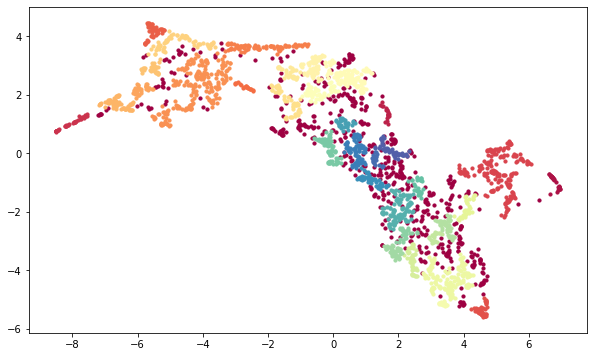

In [117]:
mpl.rcParams['figure.figsize'] = (10,6)
spec.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

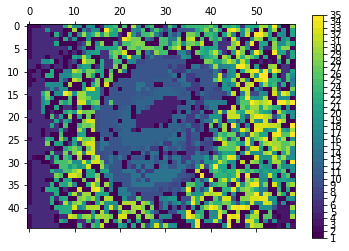

In [118]:
spec.plot_segments()

In [119]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

2020-07-02 22:46:03,204  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 5, 17, 18, 20, 21, 29, 30}
I0702 22:46:03.204902 139755279877952 segment.py:846] Assigning clusters to background: {1, 2, 3, 5, 17, 18, 20, 21, 29, 30}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

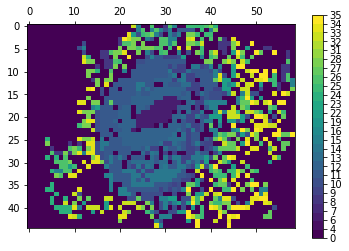

In [120]:
spec.plot_segments()

In [121]:
spec.segment(method="WARD", number_of_regions=15)

2020-07-02 22:47:38,490  SpectraRegion  INFO: Calculating clusters
I0702 22:47:38.490582 139755279877952 segment.py:724] Calculating clusters
2020-07-02 22:47:38,742  SpectraRegion  INFO: Calculating clusters done
I0702 22:47:38.742856 139755279877952 segment.py:739] Calculating clusters done
2020-07-02 22:47:38,765  SpectraRegion  INFO: Calculating clusters saved
I0702 22:47:38.765304 139755279877952 segment.py:757] Calculating clusters saved


array([[7, 7, 7, ..., 2, 2, 4],
       [7, 7, 6, ..., 2, 4, 4],
       [7, 7, 6, ..., 1, 4, 4],
       ...,
       [7, 7, 7, ..., 4, 4, 4],
       [7, 7, 7, ..., 4, 4, 4],
       [7, 7, 6, ..., 4, 4, 4]], dtype=int16)

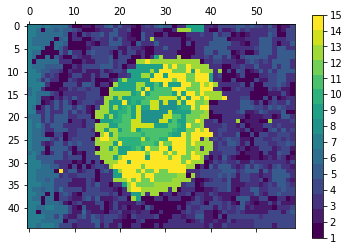

In [122]:
spec.plot_segments()

In [123]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

2020-07-02 22:47:42,115  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 4, 5, 6, 7}
I0702 22:47:42.115359 139755279877952 segment.py:846] Assigning clusters to background: {1, 2, 3, 4, 5, 6, 7}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

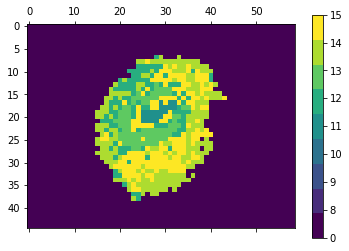

In [124]:
spec.plot_segments()

A manual curation of the segmentation is still possible!

In [13]:
spec.segmented[0:6,] = 0

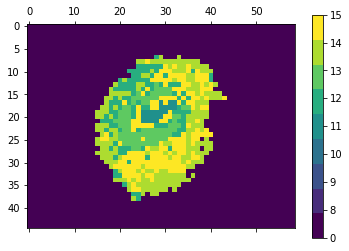

In [14]:
spec.plot_segments()

Consensus Analysis

In [126]:
spec.consensus_spectra()

2020-07-02 22:48:44,245  SpectraRegion  INFO: Calculating consensus spectra
I0702 22:48:44.245764 139755279877952 segment.py:900] Calculating consensus spectra
2020-07-02 22:48:44,301  SpectraRegion  INFO: Calculating consensus spectra done
I0702 22:48:44.301648 139755279877952 segment.py:912] Calculating consensus spectra done


{0: array([0.32858817, 0.32858817, 0.32858817, ..., 0.13814651, 0.13814651,
        0.13814651]),
 9: array([0.31465602, 0.31465602, 0.31465602, ..., 0.1443625 , 0.1443625 ,
        0.1443625 ]),
 13: array([0.27548443, 0.27548443, 0.27548443, ..., 0.15413321, 0.15413321,
        0.15413321]),
 15: array([0.28017098, 0.28017098, 0.28017098, ..., 0.14569722, 0.14569722,
        0.14569722]),
 12: array([0.34919446, 0.34919446, 0.34919446, ..., 0.13358178, 0.13358178,
        0.13358178]),
 11: array([0.48635816, 0.48635816, 0.48635816, ..., 0.12914617, 0.12914617,
        0.12914617]),
 10: array([0.30344266, 0.30344266, 0.30344266, ..., 0.12372944, 0.12372944,
        0.12372944]),
 14: array([0.36963579, 0.36963579, 0.36963579, ..., 0.10479316, 0.10479316,
        0.10479316]),
 8: array([0.4306265 , 0.4306265 , 0.4306265 , ..., 0.11657786, 0.11657786,
        0.11657786])}

In [127]:
spec.consensus_similarity()

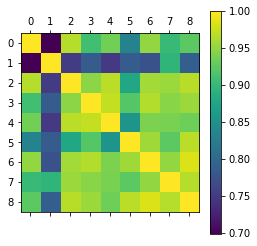

In [128]:
spec.plot_consensus_similarity()

2020-07-02 21:32:24,227  SpectraRegion  INFO: Found clusterLabels [0, 8, 9, 10, 11, 12, 13, 14, 15]
I0702 21:32:24.227107 139755279877952 segment.py:1027] Found clusterLabels [0, 8, 9, 10, 11, 12, 13, 14, 15]
2020-07-02 21:32:24,232  SpectraRegion  INFO: Processing clusterLabel 0
I0702 21:32:24.232813 139755279877952 segment.py:1035] Processing clusterLabel 0
2020-07-02 21:36:06,803  SpectraRegion  INFO: Processing clusterLabel 8
I0702 21:36:06.803857 139755279877952 segment.py:1035] Processing clusterLabel 8
2020-07-02 21:36:06,829  SpectraRegion  INFO: Processing clusterLabel 9
I0702 21:36:06.829992 139755279877952 segment.py:1035] Processing clusterLabel 9
2020-07-02 21:36:07,377  SpectraRegion  INFO: Processing clusterLabel 10
I0702 21:36:07.377123 139755279877952 segment.py:1035] Processing clusterLabel 10
2020-07-02 21:36:07,425  SpectraRegion  INFO: Processing clusterLabel 11
I0702 21:36:07.425757 139755279877952 segment.py:1035] Processing clusterLabel 11
2020-07-02 21:36:07,54

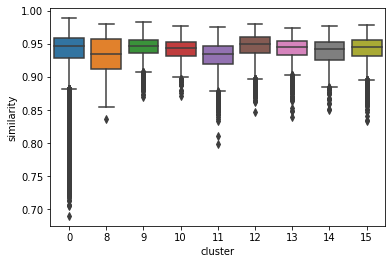

In [18]:
spec.plot_consensus_similarity(mode="spectra")

In [ ]:
#spec.plot_inter_consensus_similarity()

# Differential Analysis

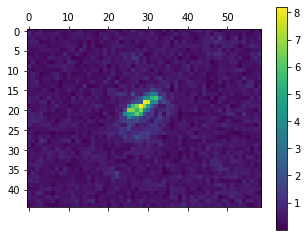

In [286]:
spec.mass_heatmap(14954, min_cut_off=0.0025)

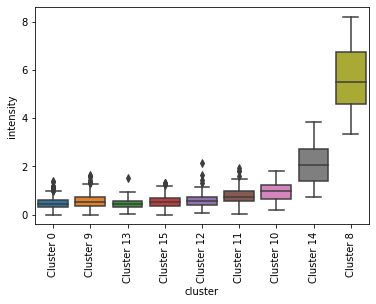

/usr/local/lib/python3.6/dist-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


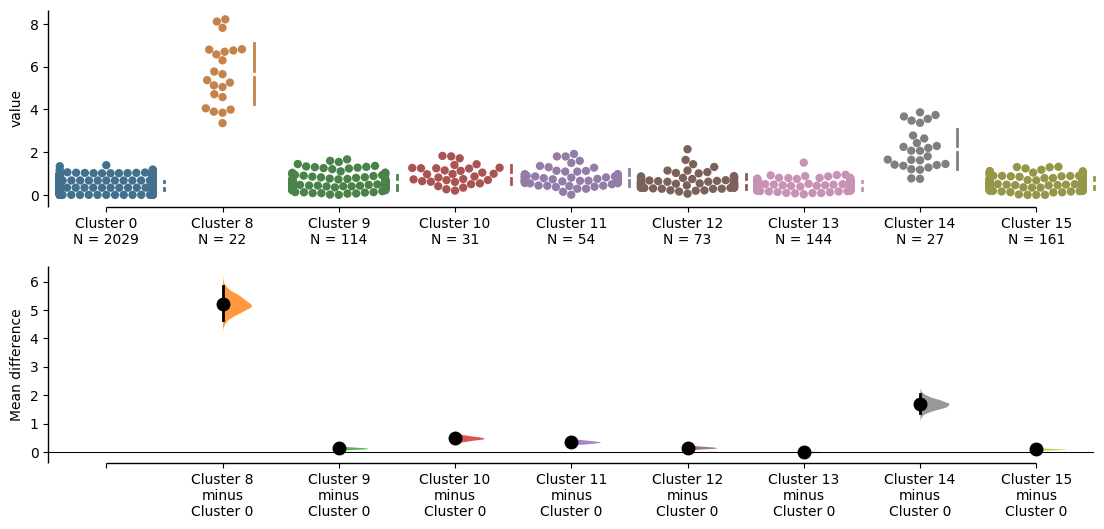

In [287]:
dfobj = spec.mass_dabest(14954)

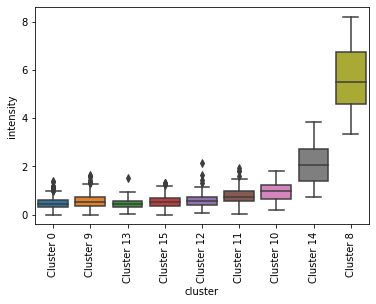

/usr/local/lib/python3.6/dist-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


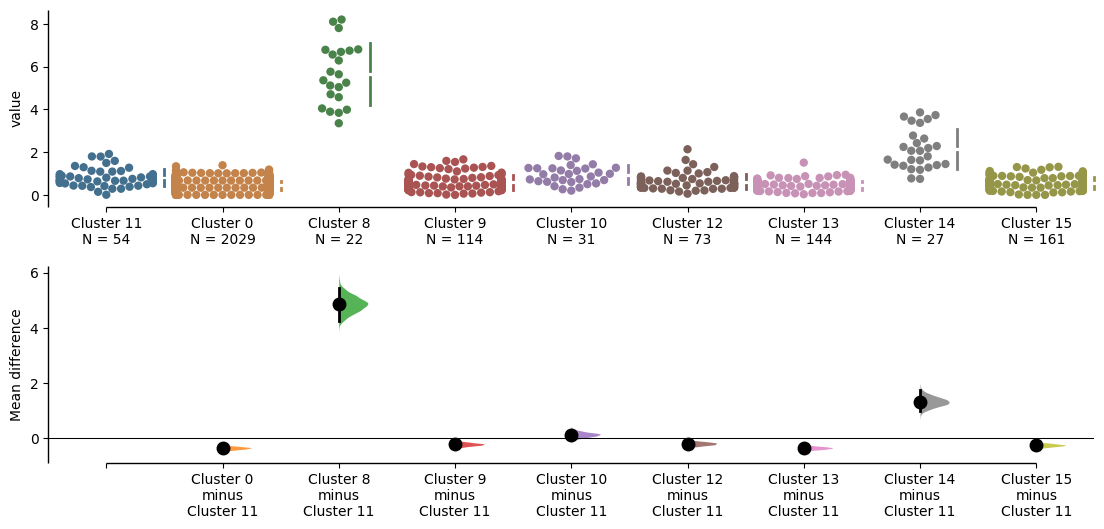

In [284]:
spec.mass_dabest(14954, background=11)

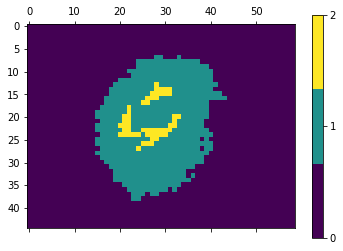

In [131]:
spec.plot_segments(highlight=11)

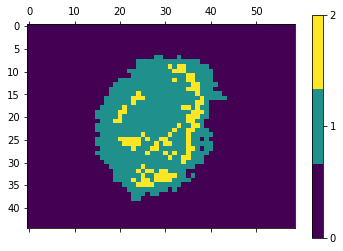

In [141]:
spec.plot_segments(highlight=[10,12])

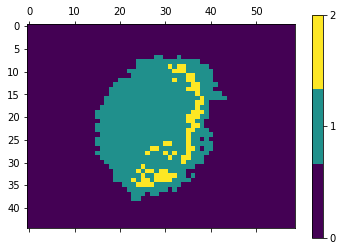

In [140]:
spec.plot_segments(highlight=12)

In [134]:
spec.clear_de_results()

In [135]:
pw = ProteinWeights("protein_weights.tsv")

In [137]:
mgenes = spec.find_all_markers(pw, includeBackground=False,
                               replaceExisting=False,
                               outdirectory="./",
                               use_methods=["ttest", "rank"])

Running [9] against [13, 15, 12, 11, 10, 14, 8]
Running [13] against [9, 15, 12, 11, 10, 14, 8]
Running [15] against [9, 13, 12, 11, 10, 14, 8]
Running [12] against [9, 13, 15, 11, 10, 14, 8]
Running [11] against [9, 13, 15, 12, 10, 14, 8]
Running [10] against [9, 13, 15, 12, 11, 14, 8]
Running [14] against [9, 13, 15, 12, 11, 10, 8]
Running [8] against [9, 13, 15, 12, 11, 10, 14]


In [147]:
mgenes_bg = spec.find_all_markers(pw, includeBackground=True, replaceExisting=False, use_methods = ["ttest", "rank"])

Running [0] against [9, 13, 15, 12, 11, 10, 14, 8]


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Running [9] against [0, 13, 15, 12, 11, 10, 14, 8]
Running [13] against [0, 9, 15, 12, 11, 10, 14, 8]
Running [15] against [0, 9, 13, 12, 11, 10, 14, 8]
Running [12] against [0, 9, 13, 15, 11, 10, 14, 8]
Running [11] against [0, 9, 13, 15, 12, 10, 14, 8]
Running [10] against [0, 9, 13, 15, 12, 11, 14, 8]
Running [14] against [0, 9, 13, 15, 12, 11, 10, 8]
Running [8] against [0, 9, 13, 15, 12, 11, 10, 14]


In [163]:
spec.list_de_results()

[('ttest', ((9,), (8, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((13,), (8, 9, 10, 11, 12, 14, 15))),
 ('ttest', ((15,), (8, 9, 10, 11, 12, 13, 14))),
 ('ttest', ((12,), (8, 9, 10, 11, 13, 14, 15))),
 ('ttest', ((11,), (8, 9, 10, 12, 13, 14, 15))),
 ('ttest', ((10,), (8, 9, 11, 12, 13, 14, 15))),
 ('ttest', ((14,), (8, 9, 10, 11, 12, 13, 15))),
 ('ttest', ((8,), (9, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((0,), (8, 9, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((9,), (0, 8, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((13,), (0, 8, 9, 10, 11, 12, 14, 15))),
 ('ttest', ((15,), (0, 8, 9, 10, 11, 12, 13, 14))),
 ('ttest', ((12,), (0, 8, 9, 10, 11, 13, 14, 15))),
 ('ttest', ((11,), (0, 8, 9, 10, 12, 13, 14, 15))),
 ('ttest', ((10,), (0, 8, 9, 11, 12, 13, 14, 15))),
 ('ttest', ((14,), (0, 8, 9, 10, 11, 12, 13, 15))),
 ('ttest', ((8,), (0, 9, 10, 11, 12, 13, 14, 15))),
 ('rank', ((9,), (8, 10, 11, 12, 13, 14, 15))),
 ('rank', ((13,), (8, 9, 10, 11, 12, 14, 15))),
 ('rank', ((15,), (8, 9, 10, 11, 12, 13, 14)

In [143]:
markerGenes = mgenes["ttest"]
markerGenes.to_csv("marker_genes.tsv", sep="\t", index=False)

In [145]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(mgenes["ttest"]["gene"]))))

Number of unique, differentially detected proteins (from masses): 239


In [148]:
markerGenesBG = mgenes_bg["ttest"]
markerGenesBG.to_csv("marker_genes_bg.tsv", sep="\t", index=False)

In [149]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(mgenes_bg["ttest"]["gene"]))))

Number of unique, differentially detected proteins (from masses): 399


In [150]:
with open("slideD_region_0.spec.pickle", "wb") as fout:
    pickle.dump(spec, fout)

In [39]:
resClus8 = spec.find_de_results( (8,) )
resClus8

[('ttest', ((8,), (9, 10, 11, 12, 13, 14, 15))),
 ('ttest', ((8,), (0, 9, 10, 11, 12, 13, 14, 15))),
 ('rank', ((8,), (9, 10, 11, 12, 13, 14, 15))),
 ('rank', ((8,), (0, 9, 10, 11, 12, 13, 14, 15)))]

In [47]:
deResDFs = spec.get_de_results( resClus8[1][1] )
deRes = spec.deres_to_df(deResDFs["ttest"], resClus8[1][1], pw)


2020-06-16 10:19:27,575  SpectraRegion  INFO: DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (17900, 7) results
I0616 10:19:27.575583 140009190655808 segment.py:966] DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (17900, 7) results
2020-06-16 10:19:27,583  SpectraRegion  INFO: DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (761, 7) results (filtered)
I0616 10:19:27.583134 140009190655808 segment.py:994] DE result for case ((8,), (9, 10, 11, 12, 13, 14, 15)) with (761, 7) results (filtered)
2020-06-16 10:19:27,764  SpectraRegion  INFO: Created matrices with shape (94, 17900) and (566, 17900) (target, bg)
I0616 10:19:27.764873 140009190655808 segment.py:1000] Created matrices with shape (94, 17900) and (566, 17900) (target, bg)


In [48]:
deRes.to_csv("region1_cluster8.tsv", sep="\t")

In [181]:
set(markerGenes[(markerGenes["clusterID"] == "14") & (markerGenes["avg_logFC"] >0.01)]["gene"])

{'Acot13',
 'Atg12',
 'Ccdc126',
 'Cend1',
 'Cisd3',
 'Fam107b',
 'Fam136a',
 'Gng7',
 'Gngt2',
 'Golga7',
 'H2afx',
 'Ifitm3',
 'Lage3',
 'Mrps14',
 'Mrps16',
 'Ndufa11',
 'ORF11',
 'Pcp4l1',
 'Pfn1',
 'Pfn2',
 'Rpl27',
 'Rps23',
 'Snapin',
 'Synj2bp',
 'Tmsb10'}

In [187]:
for x in set(markerGenes[(markerGenes["clusterID"] == "8") & (markerGenes["avg_logFC"] >0.01)]["gene"]):
    print(x)

Sco2
Snapin
Fcer1g
Fabp3
Smim4
Rps28
Nxt2
Fabp5
Emc9
Fam107b
Lgals1
Pfn2
Cox7c
Lage3
Ndufb6
Synj2bp
Gngt2
Rps14
Mrps18b
mt-Co3
S100a1
Fam136a
Npc2
H2afx
Acot13
Rps3a
Rps24
Mocs2
Ifitm3
Rps15a
Pcp4l1
Carhsp1
Nxt1
Cend1
Rps6
Arpc5
Mvb12a
Ccdc126
Ptrhd1
Pfn1
Mrps16
Cerk
Tomm20
Atp5f1
Psmb7
Ndufa11
Rpl27
Hdhd2
Golga7
Rps17
Tmsb10
Cplx1
Rpl32
Pycrl
Hbb-b2
Cdc25c
Rpl23
Exosc8
Hbb-b1
Atg12
Rps23
Mrpl55
Fam192a
Pea15
Ttr
Cisd3
Dhrs4
Pcbd2
Pkia
Fabp2
Gng7
Atox1
Rbp1
Trappc2l
Mrps14
Opalin
Pex11b
Pomp
Clic4
Mrpl54
Chchd4
Fabp7
ORF11
Tomm22
Mrpl14
Cst3


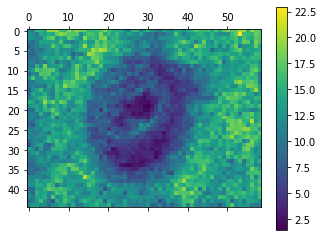

In [38]:
spec.mass_heatmap(8566.308604)

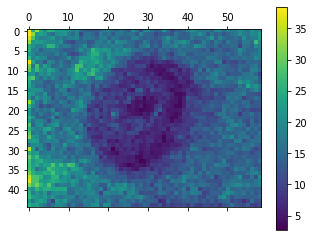

In [39]:
spec.mass_heatmap(6645.182024)

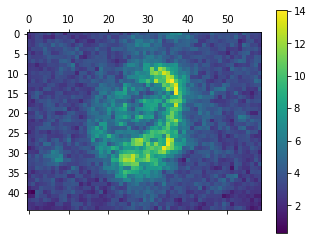

In [40]:
spec.mass_heatmap(14048.989568)

# Cell-type detection

Cell-type detection requires analyseMarkers.py from https://github.com/mjoppich/scrnaseq_celltype_prediction .

In [151]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes.tsv -n 2

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 8 clusters.
Starting analysis
8	B cells memory;Immune system	0.028806675546122172	2	66	{'GNG7', 'CD79A'}
8	Plasma cells;Immune system	0.022244553794524113	2	86	{'GNG7', 'CD79A'}
9	Monocytes;Immune system	0.0	1	102	{'IFITM3'}
11	Basophils;Immune system	0.0	1	82	{'IFITM1'}
11	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
12	Hepatocytes;Liver	0.006851267317031883	2	154	{'TTR', 'APOA2'}
12	Adipocytes;Connective tissue	0.0042170731106082795	1	120	{'APOC1'}
13	Hepatic stellate cells;Liver	0.012232185026738996	1	46	{'RBP1'}
13	Cardiomyocytes;Heart	0.0025774913310909866	1	106	{'HAMP'}
14	Monocytes;Immune system	0.008336368722491787	1	102	{'IFITM3'}
14	Gamma delta T cells;Immune system	0.007160142465323379	1	66	{'H2AFX'}
15	Mast cells;Immune system	0.

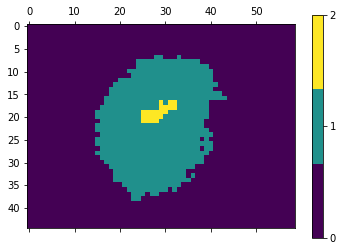

In [188]:
spec.plot_segments(highlight=(8))

In [152]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_bg.tsv -n 2

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 9 clusters.
Starting analysis
0	Hepatic stellate cells;Liver	0.01695203348480065	1	46	{'RBP1'}
0	Smooth muscle cells;Smooth muscle	0.006759006968489463	3	82	{'RBPMS2', 'PCP4L1', 'SNCG'}
8	Monocytes;Immune system	0.04031683987352325	2	102	{'S100A9', 'IFITM3'}
8	Plasma cells;Immune system	0.03523996713431488	3	86	{'CYCS', 'CD79A', 'GNG7'}
9	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
9	Hepatic stellate cells;Liver	0.0	1	46	{'RBP1'}
10	Monocytes;Immune system	0.027698917038371747	3	102	{'MGMT', 'RHOC', 'IFITM3'}
10	Mast cells;Immune system	0.00805838136884277	2	162	{'PCP4L1', 'SOCS2'}
11	Smooth muscle cells;Smooth muscle	0.0041825302516378575	2	82	{'PCP4L1', 'SNCG'}
11	B cells memory;Immune system	0.003755635366332636	1	66	{'GNG7'}
12	Myofibro

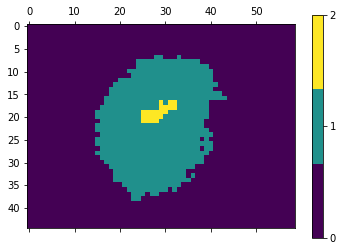

In [154]:
spec.plot_segments(highlight=(8))

In [162]:
spec.to_aorta3d("./slided_test/", "slided", 0, protWeights=pw, nodf=False, pathPrefix="../data/test_msi/")

Running [0] against [9, 13, 15, 12, 11, 10, 14, 8]
Running [9] against [0, 13, 15, 12, 11, 10, 14, 8]
Running [13] against [0, 9, 15, 12, 11, 10, 14, 8]
Running [15] against [0, 9, 13, 12, 11, 10, 14, 8]
Running [12] against [0, 9, 13, 15, 11, 10, 14, 8]
Running [11] against [0, 9, 13, 15, 12, 10, 14, 8]
Running [10] against [0, 9, 13, 15, 12, 11, 14, 8]
Running [14] against [0, 9, 13, 15, 12, 11, 10, 8]
Running [8] against [0, 9, 13, 15, 12, 11, 10, 14]


In [161]:
!ls slided_test

slided.0.info  slided.0.upgma.png


# Preparations for CombinedSpectra

Found region 1 with shape (43, 56, 17900)
I0616 13:22:15.409117 140009190655808 segment.py:1935] Found region 1 with shape (43, 56, 17900)


3454.87441091502 6
3456.383544128344 106
3457.8926773416683 2282
6651.218556735783 1
4749.710707947227 13


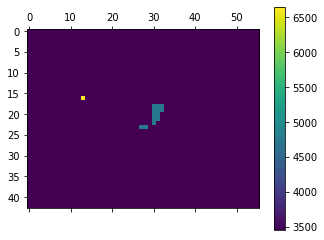

2408 0.064910434 1.0 0.41083783311057726


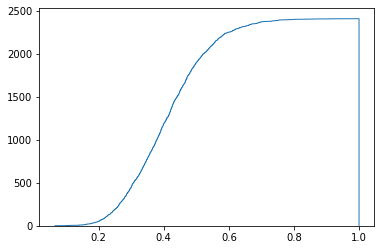

Got spectra (43, 56, 17900)
(43, 56, 17900)


2020-06-16 13:22:18,205  SpectraRegion  INFO: Creating C++ obj
2020-06-16 13:22:18,205  SpectraRegion  INFO: Creating C++ obj
I0616 13:22:18.205235 140009190655808 segment.py:264] Creating C++ obj
2020-06-16 13:22:18,207  SpectraRegion  INFO: dimensions 17900
2020-06-16 13:22:18,207  SpectraRegion  INFO: dimensions 17900
I0616 13:22:18.207868 140009190655808 segment.py:274] dimensions 17900
2020-06-16 13:22:18,213  SpectraRegion  INFO: input dimensions (43, 56, 17900)
2020-06-16 13:22:18,213  SpectraRegion  INFO: input dimensions (43, 56, 17900)
I0616 13:22:18.213472 140009190655808 segment.py:275] input dimensions (43, 56, 17900)
2020-06-16 13:22:18,219  SpectraRegion  INFO: Switching to dot mode
2020-06-16 13:22:18,219  SpectraRegion  INFO: Switching to dot mode
I0616 13:22:18.219383 140009190655808 segment.py:278] Switching to dot mode
2020-06-16 13:22:18,222  SpectraRegion  INFO: Starting calc similarity c++
2020-06-16 13:22:18,222  SpectraRegion  INFO: Starting calc similarity c++

(2408, 2408)


2020-06-16 13:25:33,807  SpectraRegion  INFO: Calculating dist pixel map done
2020-06-16 13:25:33,807  SpectraRegion  INFO: Calculating dist pixel map done
I0616 13:25:33.807442 140009190655808 segment.py:337] Calculating dist pixel map done
2020-06-16 13:25:33,898  SpectraRegion  INFO: Calculating clusters
2020-06-16 13:25:33,898  SpectraRegion  INFO: Calculating clusters
I0616 13:25:33.898677 140009190655808 segment.py:484] Calculating clusters
2020-06-16 13:25:34,166  SpectraRegion  INFO: Calculating clusters done
2020-06-16 13:25:34,166  SpectraRegion  INFO: Calculating clusters done
I0616 13:25:34.166961 140009190655808 segment.py:499] Calculating clusters done
2020-06-16 13:25:34,187  SpectraRegion  INFO: Calculating clusters saved
2020-06-16 13:25:34,187  SpectraRegion  INFO: Calculating clusters saved
I0616 13:25:34.187759 140009190655808 segment.py:517] Calculating clusters saved


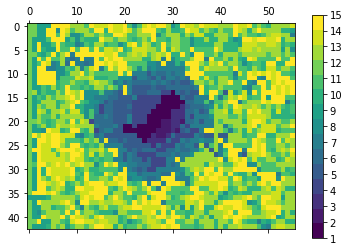

In [51]:
spectra1 = imze.get_region_array(1, makeNullLine=True)
imze.normalize_region_array(spectra1, normalize="vector")
imze.list_highest_peaks(spectra1, counter=True)
print("Got spectra", spectra1.shape)

spec1 = SpectraRegion(spectra1, imze.mzValues)
spec1.calculate_similarity(mode="spectra_log_dist")
spec1.segment(method="WARD", number_of_regions=15)
spec1.plot_segments()

In [196]:
def process_imzeregion(imze, regionID, basename):
    
    print("Processing regionID", regionID, "for basename", basename)
    
    spectra_orig = imze.get_region_array(regionID, makeNullLine=True)
    spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")
    spectra = imze.normalize_region_array(spectra_intra, normalize="inter_median")
    
    rspec = SpectraRegion(spectra, imze.mzValues, name=basename + "_" + str(regionID))
    rspec.calculate_similarity(mode="spectra_log_dist")
    rspec.segment(method="WARD", number_of_regions=15)
    rspec.plot_segments()
    
    rspec.filter_clusters(method='remove_singleton')
    rspec.filter_clusters(method='merge_background')
    rspec.filter_clusters(method='remove_islands')
    rspec.plot_segments()
    
    rspec.consensus_spectra()
    rspec.consensus_similarity()
    rspec.plot_consensus_similarity()
    
    mgenes = rspec.find_all_markers(pw, includeBackground=False, replaceExisting=False, use_methods = ["ttest", "rank"])
    mgenes_bg = rspec.find_all_markers(pw, includeBackground=True, replaceExisting=False, use_methods = ["ttest", "rank"])
    
    return rspec, mgenes, mgenes_bg
    

Processiong regionID 1 for basename slideD
(43, 56, 17900)
17900
(2408, 2408)


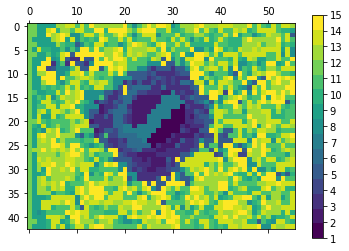

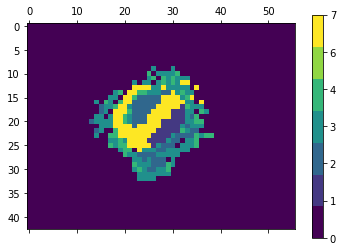

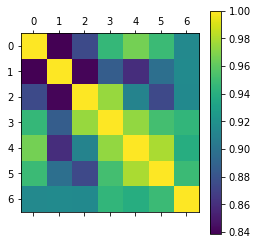

Running [3] against [4, 6, 2, 7, 1]


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Running [4] against [3, 6, 2, 7, 1]
Running [6] against [3, 4, 2, 7, 1]
Running [2] against [3, 4, 6, 7, 1]
Running [7] against [3, 4, 6, 2, 1]
Running [1] against [3, 4, 6, 2, 7]
Running [0] against [3, 4, 6, 2, 7, 1]
Running [3] against [0, 4, 6, 2, 7, 1]
Running [4] against [0, 3, 6, 2, 7, 1]
Running [6] against [0, 3, 4, 2, 7, 1]
Running [2] against [0, 3, 4, 6, 7, 1]
Running [7] against [0, 3, 4, 6, 2, 1]
Running [1] against [0, 3, 4, 6, 2, 7]


In [197]:
slided_1, slided1_mgenes, slided1_mgenes_bg = process_imzeregion(imze=imze, regionID= 1, basename="slideD")

Processiong regionID 4 for basename slideD
(49, 56, 17900)
17900
(2744, 2744)


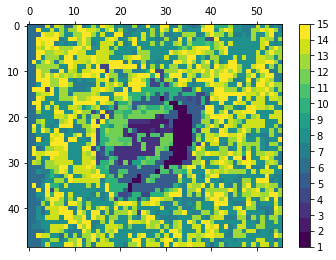

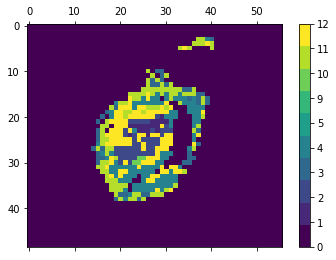

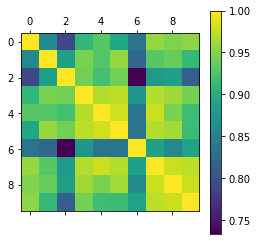

Running [10] against [5, 4, 11, 12, 1, 3, 2, 9]
Running [5] against [10, 4, 11, 12, 1, 3, 2, 9]
Running [4] against [10, 5, 11, 12, 1, 3, 2, 9]
Running [11] against [10, 5, 4, 12, 1, 3, 2, 9]
Running [12] against [10, 5, 4, 11, 1, 3, 2, 9]
Running [1] against [10, 5, 4, 11, 12, 3, 2, 9]
Running [3] against [10, 5, 4, 11, 12, 1, 2, 9]
Running [2] against [10, 5, 4, 11, 12, 1, 3, 9]
Running [9] against [10, 5, 4, 11, 12, 1, 3, 2]
Running [0] against [10, 5, 4, 11, 12, 1, 3, 2, 9]
Running [10] against [0, 5, 4, 11, 12, 1, 3, 2, 9]
Running [5] against [0, 10, 4, 11, 12, 1, 3, 2, 9]
Running [4] against [0, 10, 5, 11, 12, 1, 3, 2, 9]
Running [11] against [0, 10, 5, 4, 12, 1, 3, 2, 9]
Running [12] against [0, 10, 5, 4, 11, 1, 3, 2, 9]
Running [1] against [0, 10, 5, 4, 11, 12, 3, 2, 9]
Running [3] against [0, 10, 5, 4, 11, 12, 1, 2, 9]
Running [2] against [0, 10, 5, 4, 11, 12, 1, 3, 9]
Running [9] against [0, 10, 5, 4, 11, 12, 1, 3, 2]
Processiong regionID 5 for basename slideD
(52, 59, 17900)

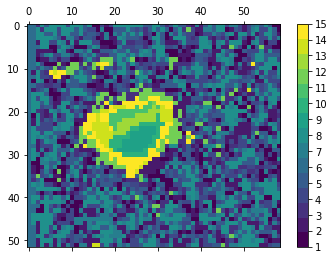

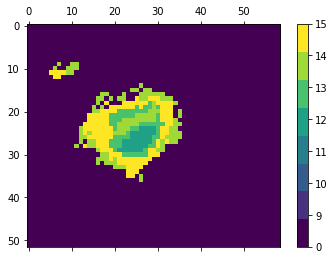

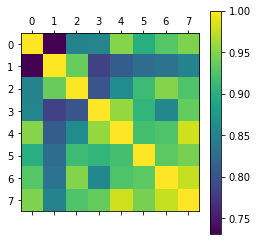

Running [12] against [15, 14, 11, 13, 10, 9]
Running [15] against [12, 14, 11, 13, 10, 9]
Running [14] against [12, 15, 11, 13, 10, 9]
Running [11] against [12, 15, 14, 13, 10, 9]
Running [13] against [12, 15, 14, 11, 10, 9]
Running [10] against [12, 15, 14, 11, 13, 9]
Running [9] against [12, 15, 14, 11, 13, 10]
Running [0] against [12, 15, 14, 11, 13, 10, 9]
Running [12] against [0, 15, 14, 11, 13, 10, 9]
Running [15] against [0, 12, 14, 11, 13, 10, 9]
Running [14] against [0, 12, 15, 11, 13, 10, 9]
Running [11] against [0, 12, 15, 14, 13, 10, 9]
Running [13] against [0, 12, 15, 14, 11, 10, 9]
Running [10] against [0, 12, 15, 14, 11, 13, 9]
Running [9] against [0, 12, 15, 14, 11, 13, 10]


In [215]:
slided_4, slided4_mgenes, slided4_mgenes_bg = process_imzeregion(imze=imze, regionID= 4, basename="slideD")
slided_5, slided5_mgenes, slided5_mgenes_bg = process_imzeregion(imze=imze, regionID= 5, basename="slideD")

In [216]:
markerGenes1 = slided1_mgenes_bg["ttest"]
markerGenes1.to_csv("marker_genes_region_1.tsv", sep="\t", index=False)
markerGenes4 = slided4_mgenes_bg["ttest"]
markerGenes4.to_csv("marker_genes_region_4.tsv", sep="\t", index=False)
markerGenes5 = slided5_mgenes_bg["ttest"]
markerGenes5.to_csv("marker_genes_region_5.tsv", sep="\t", index=False)


In [200]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_1.tsv -n 2

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 7 clusters.
Starting analysis
0	Hepatic stellate cells;Liver	0.02856601463186955	1	46	{'RBP1'}
0	Hepatocytes;Liver	0.007425129236721896	3	154	{'APOA2', 'HAMP', 'TTR'}
1	B cells;Immune system	0.0019772781472016166	1	110	{'HMGA1'}
1	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
2	Myofibroblasts;Smooth muscle	0.020122073311544166	1	9	{'TAGLN'}
2	Smooth muscle cells;Smooth muscle	0.0182686038592259	3	82	{'SNCG', 'RBPMS2', 'TAGLN'}
3	Hepatocytes;Liver	0.007272490868621124	2	154	{'APOA2', 'TTR'}
3	Smooth muscle cells;Smooth muscle	0.0068030485188313805	2	82	{'SNCG', 'RBPMS2'}
4	Chondrocytes;Connective tissue	0.0	1	52	{'S100A9'}
4	Dendritic cells;Immune system	0.0	1	133	{'S100A9'}
6	Plasma cells;Immune system	0.0030172647861467002	1	86	{'CYCS'}
6	En

In [217]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_4.tsv -n 2

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 10 clusters.
Starting analysis
0	Hepatic stellate cells;Liver	0.018444880022532452	1	46	{'RBP1'}
0	Smooth muscle cells;Smooth muscle	0.007654152967731738	3	82	{'PCP4L1', 'RBPMS2', 'SNCG'}
1	Myofibroblasts;Smooth muscle	0.021204570971768092	1	9	{'TAGLN'}
1	Smooth muscle cells;Smooth muscle	0.01844810516696675	3	82	{'RBPMS2', 'SNCG', 'TAGLN'}
2	Smooth muscle cells;Smooth muscle	0.04981149684206442	4	82	{'PCP4L1', 'RBPMS2', 'SNCG', 'TAGLN'}
2	Monocytes;Immune system	0.03776884805339728	2	102	{'MGMT', 'IFITM3'}
3	Monocytes;Immune system	0.008202656209322555	1	102	{'IFITM3'}
3	Smooth muscle cells;Smooth muscle	0.00342668734326158	1	82	{'PCP4L1'}
5	Hepatocytes;Liver	0.011508593638362728	2	154	{'HAMP', 'APOA2'}
5	Smooth muscle cells;Smooth mus

In [218]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_5.tsv -n 2

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 8 clusters.
Starting analysis
0	Hepatic stellate cells;Liver	0.014700928087205158	1	46	{'RBP1'}
0	Smooth muscle cells;Smooth muscle	0.0023490874852997216	1	82	{'SNCG'}
9	Erythroid-like and erythroid precursor cells;Blood	0.010724114328683369	1	82	{'SNCA'}
9	B cells;Immune system	0.0026914238356083977	1	110	{'HMGA1'}
10	Cardiomyocytes;Heart	0.0	1	106	{'HAMP'}
10	Gamma delta T cells;Immune system	0.0	1	66	{'H2AFX'}
11	Myofibroblasts;Smooth muscle	0.021868437626499926	1	9	{'TAGLN'}
11	Smooth muscle cells;Smooth muscle	0.016752024592336708	3	82	{'TAGLN', 'RBPMS2', 'SNCG'}
13	Myofibroblasts;Smooth muscle	0.018769385776322742	1	9	{'TAGLN'}
13	Hepatic stellate cells;Liver	0.007344539372085439	2	46	{'RBP1', 'TAGLN'}
14	Chondrocytes;Connective t

# Creating a CombinedSpectra

In [220]:
spec.name = "slided_0"
slided_0 = spec
slided_1.name = "slided_1"
slided_4.name = "slided_4"
slided_5.name = "slided_5"

In [221]:
slided_0.to_pickle("slideD_region_0.pickle")
slided_1.to_pickle("slideD_region_1.pickle")
slided_4.to_pickle("slideD_region_4.pickle")
slided_5.to_pickle("slideD_region_5.pickle")

In [235]:
combSpec = CombinedSpectra({0: spec, 1: slided_1, 4: slided_4, 5: slided_5})

In [236]:
combSpec.consensus_similarity()

In [237]:
combSpec.consensus_similarity_matrix

,"(slided_0, 0)","(slided_0, 8)","(slided_0, 9)","(slided_0, 10)","(slided_0, 11)","(slided_0, 12)","(slided_0, 13)","(slided_0, 14)","(slided_0, 15)","(slided_1, 0)",...,"(slided_4, 11)","(slided_4, 12)","(slided_5, 0)","(slided_5, 9)","(slided_5, 10)","(slided_5, 11)","(slided_5, 12)","(slided_5, 13)","(slided_5, 14)","(slided_5, 15)"
"(slided_0, 0)",1.000000,0.698368,0.966462,0.909174,0.935436,0.833292,0.950625,0.903281,0.923898,0.978571,...,0.937245,0.945435,0.972481,0.691882,0.824731,0.803715,0.902065,0.864312,0.900962,0.908582
"(slided_0, 8)",0.698368,1.000000,0.751820,0.786093,0.748835,0.786261,0.774947,0.895964,0.788293,0.724216,...,0.788810,0.740944,0.727190,0.595455,0.643432,0.774120,0.776559,0.720369,0.709558,0.762815
"(slided_0, 9)",0.966462,0.751820,1.000000,0.947858,0.968912,0.879404,0.958027,0.954727,0.967560,0.971236,...,0.988055,0.982342,0.965065,0.709235,0.857914,0.855679,0.918744,0.903253,0.943628,0.947286
"(slided_0, 10)",0.909174,0.786093,0.947858,1.000000,0.972504,0.920514,0.965541,0.946929,0.954780,0.916741,...,0.965088,0.966813,0.919405,0.827471,0.910453,0.914776,0.951803,0.920611,0.965308,0.977362
"(slided_0, 11)",0.935436,0.748835,0.968912,0.972504,1.000000,0.854705,0.940316,0.939766,0.933647,0.938619,...,0.965719,0.992157,0.936056,0.796934,0.926638,0.847679,0.911942,0.935929,0.974826,0.956005
"(slided_0, 12)",0.833292,0.786261,0.879404,0.920514,0.854705,1.000000,0.956993,0.923887,0.969052,0.863513,...,0.927846,0.860329,0.870250,0.757644,0.782825,0.981014,0.959559,0.875174,0.849420,0.933975
"(slided_0, 13)",0.950625,0.774947,0.958027,0.965541,0.940316,0.956993,1.000000,0.951682,0.983659,0.961277,...,0.971734,0.947427,0.964575,0.782766,0.859020,0.938309,0.984228,0.917188,0.929605,0.974648
"(slided_0, 14)",0.903281,0.895964,0.954727,0.946929,0.939766,0.923887,0.951682,1.000000,0.966730,0.923858,...,0.973911,0.943804,0.923001,0.725563,0.832812,0.913849,0.934804,0.916508,0.910617,0.943655
"(slided_0, 15)",0.923898,0.788293,0.967560,0.954780,0.933647,0.969052,0.983659,0.966730,1.000000,0.943589,...,0.987374,0.944278,0.943324,0.743840,0.835023,0.945434,0.963413,0.912574,0.915005,0.963379
"(slided_1, 0)",0.978571,0.724216,0.971236,0.916741,0.938619,0.863513,0.961277,0.923858,0.943589,1.000000,...,0.954391,0.953567,0.998607,0.718929,0.846051,0.842593,0.940972,0.895209,0.926423,0.941992


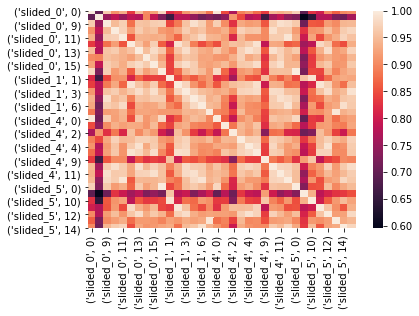

In [238]:
combSpec.plot_consensus_similarity()

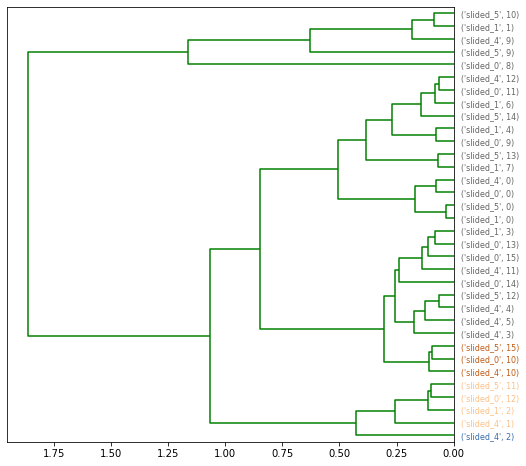

In [239]:
combSpec.cluster_concensus_spectra(number_of_clusters=10)

In [240]:
combSpec.region_cluster2cluster

{('slided_0', 0): 5,
 ('slided_0', 8): 10,
 ('slided_0', 9): 7,
 ('slided_0', 10): 3,
 ('slided_0', 11): 7,
 ('slided_0', 12): 1,
 ('slided_0', 13): 4,
 ('slided_0', 14): 4,
 ('slided_0', 15): 4,
 ('slided_1', 0): 5,
 ('slided_1', 1): 8,
 ('slided_1', 2): 1,
 ('slided_1', 3): 4,
 ('slided_1', 4): 7,
 ('slided_1', 6): 7,
 ('slided_1', 7): 6,
 ('slided_4', 0): 5,
 ('slided_4', 1): 1,
 ('slided_4', 2): 2,
 ('slided_4', 3): 4,
 ('slided_4', 4): 4,
 ('slided_4', 5): 4,
 ('slided_4', 9): 8,
 ('slided_4', 10): 3,
 ('slided_4', 11): 4,
 ('slided_4', 12): 7,
 ('slided_5', 0): 5,
 ('slided_5', 9): 9,
 ('slided_5', 10): 8,
 ('slided_5', 11): 1,
 ('slided_5', 12): 4,
 ('slided_5', 13): 6,
 ('slided_5', 14): 7,
 ('slided_5', 15): 3}

{1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7, 8.0: 8, 9.0: 9, 10.0: 10}
{0: 5, 8: 10, 9: 7, 10: 3, 11: 7, 12: 1, 13: 4, 14: 4, 15: 4}
{0: 5, 1: 8, 2: 1, 3: 4, 4: 7, 6: 7, 7: 6}
{0: 5, 1: 1, 2: 2, 3: 4, 4: 4, 5: 4, 9: 8, 10: 3, 11: 4, 12: 7}
{0: 5, 9: 9, 10: 8, 11: 1, 12: 4, 13: 6, 14: 7, 15: 3}


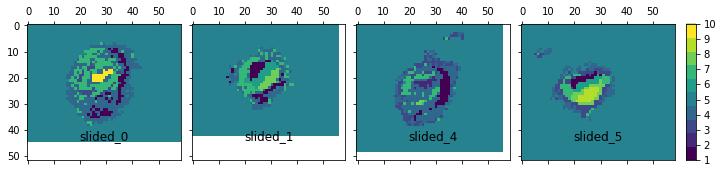

In [241]:
combSpec.plot_common_segments()

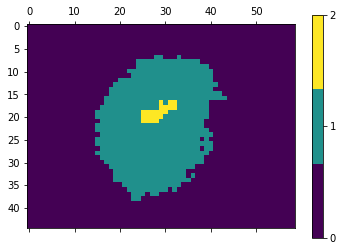

In [285]:
slided_0.plot_segments(highlight=(8))

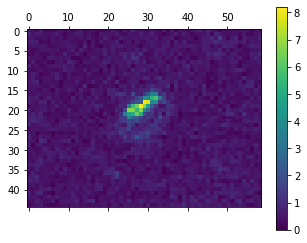

In [270]:
slided_0.mass_heatmap(14954)

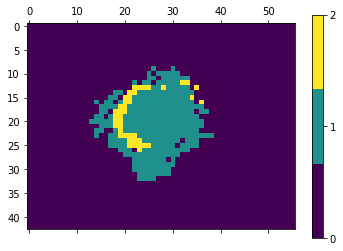

In [231]:
slided_1.plot_segments(highlight=(6))

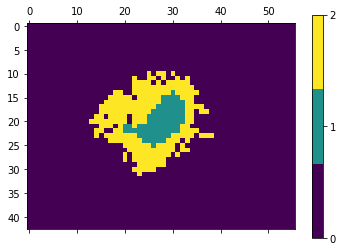

In [82]:
spec1.plot_segments(highlight=(4,5,6))

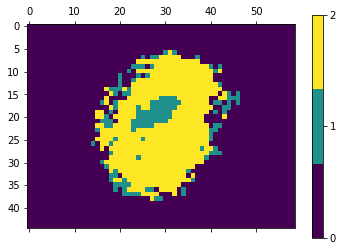

In [85]:
spec.plot_segments(highlight=(9,10,11,13,15))

In [242]:
[x for x in combSpec.regions]

['slided_0', 'slided_1', 'slided_4', 'slided_5']

In [259]:
resdf11_6, expr, pdata = combSpec.find_markers("slided_0", [11], "slided_1", [6], pw)

Running slided_0 [11] against slided_1 [6]


In [264]:
mydf = resdf11_6["ttest"][('slided_0', (11,), 'slided_1', (6,))]

In [265]:
mydf[mydf["gene"] == "Ifitm3"]

,clusterID,gene_ident,gene_mass,gene,protein_mass,avg_logFC,qvalue,num,anum,mean,median,num_bg,anum_bg,mean_bg,median_bg
408,"s,l,i,d,e,d,_,0",mass_14951_451230019162,14951.451230,Ifitm3,14954.0,-0.706580,0.000177,54,53,0.743326,0.687032,41,40,0.455489,0.456915
409,"s,l,i,d,e,d,_,0",mass_14952_960363232487,14952.960363,Ifitm3,14954.0,-0.765812,0.000107,54,53,0.768698,0.745308,41,40,0.452089,0.367835
411,"s,l,i,d,e,d,_,0",mass_14954_46949644581,14954.469496,Ifitm3,14954.0,-0.787856,0.000145,54,54,0.812664,0.739340,41,40,0.470698,0.390881
413,"s,l,i,d,e,d,_,0",mass_14955_978629659136,14955.978630,Ifitm3,14954.0,-0.844915,0.000051,54,54,0.881298,0.851834,41,39,0.490657,0.400159


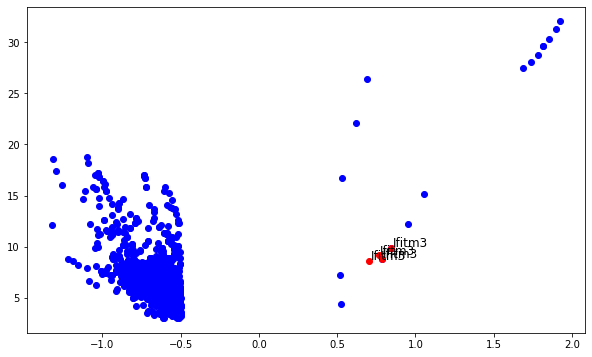

In [283]:
plt.figure(figsize=(10,6))
xydots = [(x,y) for x,y in zip(list(-mydf["avg_logFC"]), list(-np.log(mydf["qvalue"])))]
dotgene = list(mydf["gene"])

for i in range(len(xydots)):
    x = xydots[i][0]
    y = xydots[i][1]
    
    if dotgene[i] in ["Ifitm3"]:
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[i], fontsize=12)
        plt.plot(x, y, 'ro')
    else:
        plt.plot(x, y, 'bo')

plt.show()

In [90]:
markerGenes4 = mgenes4["ttest"]
markerGenes4.to_csv("marker_genes_region_4.tsv", sep="\t", index=False)

In [91]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_4.tsv -n 4

Taking value gene from gene
Taking value cluster from clusterID
Taking value logfc from avg_logFC
Taking value pvaladj from qvalue
Taking value expr-mean from mean
Taking value expressing-cell-count from num
Taking value cluster-cell-count from anum
Got 8 clusters.
Starting analysis
1	Hepatic stellate cells;Liver	0.0	1	46	{'RBP1'}
2	Basal cells;Epithelium	0.0	1	56	{'DUSP23'}
2	Basophils;Immune system	0.0	2	82	{'IFITM1', 'IGFBP7'}
2	Cardiomyocytes;Heart	0.0	2	106	{'HAMP', 'TNNC1'}
2	Dendritic cells;Immune system	0.0	1	133	{'LGALS3'}
3	Basophils;Immune system	0.0	1	82	{'IFITM1'}
3	Endothelial cells;Vasculature	0.0	1	195	{'GNG11'}
3	Gamma delta T cells;Immune system	0.0	1	66	{'IFITM1'}
3	Hepatocytes;Liver	0.0	1	154	{'APOA2'}
4	Monocytes;Immune system	0.0	1	102	{'IFITM3'}
5	Platelets;Blood	0.01923820860566426	3	131	{'HIST1H2BC', 'PF4', 'HIST1H2BK'}
5	Hepatic stellate cells;Liver	0.019232762881040973	2	46	{'IGFBP7', 'RBP1'}
5	Monocytes;Immune system	0.012478663043020326	1	102	{'IFITM3'}
5	H